In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt


In [11]:
# -----------------------------
# 🧱 Residual Block
# -----------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        residual = x
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        return F.relu(x + residual)


In [12]:
# -----------------------------
# 🧠 Feature Encoder
# -----------------------------
class FeatureEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, padding=3)
        self.res1 = ResidualBlock(64)
        self.res2 = ResidualBlock(64)
        self.out = nn.Conv2d(64, 128, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.res1(x)
        x = self.res2(x)
        return self.out(x)

In [13]:
# -----------------------------
# 🧠 Context Encoder
# -----------------------------
class ContextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, padding=3)
        self.res1 = ResidualBlock(64)
        self.res2 = ResidualBlock(64)
        # Output has 128 hidden + 128 input channels
        self.out = nn.Conv2d(64, 256, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.res1(x)
        x = self.res2(x)
        return self.out(x)

In [14]:
# -----------------------------
# 🔁 Conv-GRU Block
# -----------------------------
class ConvGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.convz = nn.Conv2d(input_dim + hidden_dim, hidden_dim, 3, padding=1)
        self.convr = nn.Conv2d(input_dim + hidden_dim, hidden_dim, 3, padding=1)
        self.convq = nn.Conv2d(input_dim + hidden_dim, hidden_dim, 3, padding=1)

    def forward(self, x, h):
        # Concatenate input + hidden state
        combined = torch.cat([x, h], dim=1)
        z = torch.sigmoid(self.convz(combined))  # update gate
        r = torch.sigmoid(self.convr(combined))  # reset gate
        q = torch.tanh(self.convq(torch.cat([x, r * h], dim=1)))
        return (1 - z) * h + z * q


In [15]:
# -----------------------------
# 🔁 All-Pairs Correlation
# -----------------------------
def compute_correlation(fmap1, fmap2):
    B, C, H, W = fmap1.shape
    fmap1 = fmap1.view(B, C, H * W)
    fmap2 = fmap2.view(B, C, H * W)
    corr = torch.matmul(fmap1.transpose(1, 2), fmap2)  # [B, HW, HW]
    return corr.view(B, H, W, H, W)  # [B, H1, W1, H2, W2]


In [16]:
# -----------------------------
# 🔽 Correlation Pyramid (multi-scale)
# -----------------------------
def build_correlation_pyramid(corr, levels=4):
    pyr = [corr]
    for i in range(1, levels):
        # Average pooling to build pyramid
        corr = F.avg_pool3d(corr, (1, 2, 2), stride=(1, 2, 2))
        pyr.append(corr)
    return pyr

In [17]:
# -----------------------------
# 🧠 Flow Head (predicts delta flow)
# -----------------------------
class FlowHead(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(input_dim, hidden_dim, 3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, 2, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return self.conv2(x)

In [18]:
# -----------------------------
# 🎯 RAFT Model
# -----------------------------
class RAFT(nn.Module):
    def __init__(self):
        super().__init__()
        self.fnet = FeatureEncoder()
        self.cnet = ContextEncoder()
        self.update_block = ConvGRU(input_dim=128 + 2, hidden_dim=128)
        self.flow_head = FlowHead()

    def initialize_flow(self, img):
        """Creates coordinate grids"""
        B, _, H, W = img.shape
        coords = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
        coords = torch.stack(coords[::-1], dim=0).float()  # [2, H, W] (x,y order)
        coords = coords[None].repeat(B, 1, 1, 1).to(img.device)  # [B, 2, H, W]
        return coords, coords.clone()

    def forward(self, image1, image2, iters=12):
        fmap1 = self.fnet(image1)
        fmap2 = self.fnet(image2)

        # Correlation volume
        corr = compute_correlation(fmap1, fmap2)  # [B, H1, W1, H2, W2]
        corr_pyramid = build_correlation_pyramid(corr)

        # Context features
        context = self.cnet(image1)
        net, inp = torch.split(context, [128, 128], dim=1)

        # Initialize coordinates
        coords0, coords1 = self.initialize_flow(image1)

        for _ in range(iters):
            flow = coords1 - coords0  # current flow
            flow_input = torch.cat([inp, flow], dim=1)
            net = self.update_block(flow_input, net)
            delta_flow = self.flow_head(net)
            coords1 = coords1 + delta_flow

        return coords1 - coords0  # final flow prediction

Saving WhatsApp Image 2025-09-24 at 23.12.22_861c8fff.jpg to WhatsApp Image 2025-09-24 at 23.12.22_861c8fff (2).jpg
Saving WhatsApp Image 2025-09-24 at 23.12.22_9579ae4c.jpg to WhatsApp Image 2025-09-24 at 23.12.22_9579ae4c (1).jpg
Uploaded files: ['WhatsApp Image 2025-09-24 at 23.12.22_861c8fff (2).jpg', 'WhatsApp Image 2025-09-24 at 23.12.22_9579ae4c (1).jpg']
Predicted flow shape: torch.Size([1, 2, 128, 128])


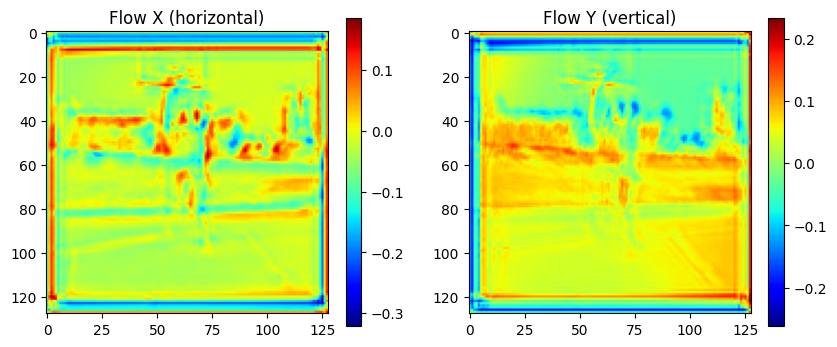

In [22]:
from google.colab import files
from PIL import Image
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt

# -----------------------------
# 🚀 Run Demo with Two Images
# -----------------------------
if __name__ == "__main__":
    # Upload images manually
    uploaded = files.upload()

    # Convert dict keys to list
    filenames = list(uploaded.keys())
    print("Uploaded files:", filenames)

    if len(filenames) < 2:
        raise ValueError("Please upload at least 2 images!")

    # Pick the first two images
    img1 = Image.open(filenames[0]).convert("RGB")
    img2 = Image.open(filenames[1]).convert("RGB")

    # Transform: resize + convert to tensor
    transform = T.Compose([
        T.Resize((128, 128)),
        T.ToTensor()
    ])

    image1 = transform(img1).unsqueeze(0)
    image2 = transform(img2).unsqueeze(0)

    # Load RAFT model
    model = RAFT()
    model.eval()

    # Run inference
    with torch.no_grad():
        flow = model(image1, image2, iters=12)

    print("Predicted flow shape:", flow.shape)

    # Visualize flow
    flow_x = flow[0, 0].cpu().numpy()
    flow_y = flow[0, 1].cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Flow X (horizontal)")
    plt.imshow(flow_x, cmap="jet")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title("Flow Y (vertical)")
    plt.imshow(flow_y, cmap="jet")
    plt.colorbar()

    plt.show()


In [23]:
import numpy as np

# flow: [1, 2, H, W]
flow_np = flow[0].cpu().numpy()
flow_x = flow_np[0]  # horizontal displacement
flow_y = flow_np[1]  # vertical displacement

# Motion magnitude per pixel
magnitude = np.sqrt(flow_x**2 + flow_y**2)

# Average motion across the whole image
avg_motion = np.mean(magnitude)

print("Average pixel displacement:", avg_motion)


Average pixel displacement: 0.08162831
